<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Training/Burgers_1D_pinns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [3]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [4]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [5]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.12372642010450363
200 0.08979766070842743
300 0.07694289088249207
400 0.054536305367946625
500 0.036619432270526886
600 0.023026572540402412
700 0.02656956948339939
800 0.02127496339380741
900 0.014454497024416924
1000 0.013282973319292068
1100 0.00782189704477787
1200 0.004682140424847603
1300 0.003186488524079323
1400 0.002374368254095316
1500 0.0018122007604688406
1600 0.001318072434514761
1700 0.0009769692551344633
1800 0.0007493498269468546
1900 0.0017874031327664852
2000 0.0004987785359844565
2100 0.0004087886190973222
2200 0.00033979519503191113
2300 0.0003084651252720505
2400 0.0002899994724430144
2500 0.00027516254340298474
2600 0.0002542761212680489
2700 0.00022962034563533962
2800 0.00021102503524161875
2900 0.0001961666566785425
3000 0.00017901320825330913
3100 0.00017094239592552185
3200 0.00016345079347956926
3300 0.00015709095168858767
3400 0.00015750655438750982
3500 0.00014446035493165255
3600 0.00013341102749109268
3700 0.00012672875891439617
3800 0.000122933299

In [6]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [8]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]])

In [9]:
X.shape

torch.Size([20000, 2])

In [10]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [11]:
y_pred.shape

(200, 100)

In [12]:
y_pred

array([[ 0.0017226 ,  0.00131023,  0.00096917, ..., -0.00202435,
        -0.00203446, -0.00204223],
       [ 0.03378817,  0.03238198,  0.03110072, ...,  0.0057179 ,
         0.0056507 ,  0.00558713],
       [ 0.06563911,  0.06325749,  0.06105372, ...,  0.01345798,
         0.01333371,  0.01321378],
       ...,
       [-0.09507102, -0.09239087, -0.08981648, ..., -0.02500859,
        -0.02480635, -0.02460602],
       [-0.06312427, -0.06141126, -0.05974665, ..., -0.01713958,
        -0.01699695, -0.01685631],
       [-0.0309054 , -0.03017947, -0.0294432 , ..., -0.00926757,
        -0.0091857 , -0.00910461]], dtype=float32)

In [13]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

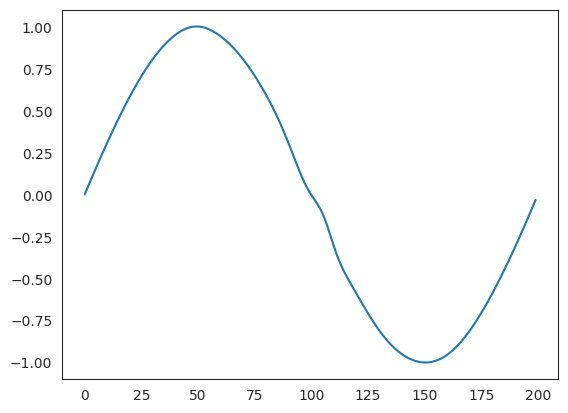

In [14]:
plt.plot(y_pred[:,0])

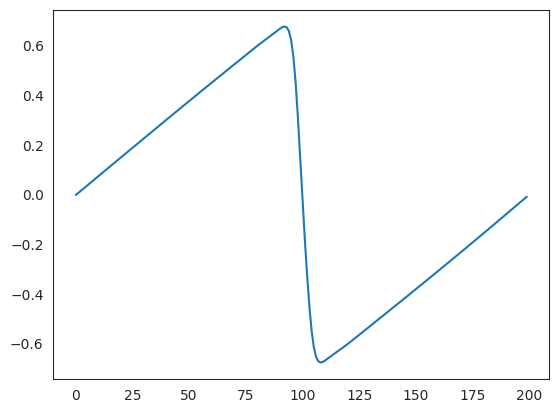

In [15]:
plt.plot(y_pred[:,-1])

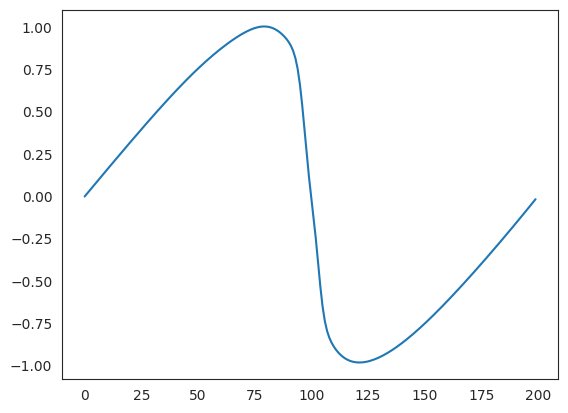

In [16]:
plt.plot(y_pred[:,30])